In [1]:
# Generated by Copilot
# Core imports
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import random
import logging

# Add project root to path
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))


from tqdm.notebook import tqdm

In [ ]:
image = cv2.imread("data/dataset/images/0004.jpg")
if image is None:
    raise ValueError("Image not found or unable to read")
print(f"Image shape: {image.shape}")
# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.axis("off")  # Hide axes
plt.show()

In [ ]:
# Preprocessing Pipeline
from PIL import Image


def normalizeStaining(img, Io=240, alpha=1, beta=0.15):
    """Normalize staining appearence of H&E stained images

    Example use:
        see test.py

    Input:
        I: RGB input image
        Io: (optional) transmitted light intensity

    Output:
        Inorm: normalized image
        H: hematoxylin image
        E: eosin image

    Reference:
        A method for normalizing histology slides for quantitative analysis. M.
        Macenko et al., ISBI 2009
    """

    HERef = np.array([[0.5626, 0.2159], [0.7201, 0.8012], [0.4062, 0.5581]])

    maxCRef = np.array([1.9705, 1.0308])

    # define height and width of image
    h, w, c = img.shape

    # reshape image
    img = img.reshape((-1, 3))

    # calculate optical density
    OD = -np.log((img.astype(float) + 1) / Io)

    # remove transparent pixels
    ODhat = OD[~np.any(OD < beta, axis=1)]

    # compute eigenvectors
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

    # eigvecs *= -1

    # project on the plane spanned by the eigenvectors corresponding to the two
    # largest eigenvalues
    That = ODhat.dot(eigvecs[:, 1:3])

    phi = np.arctan2(That[:, 1], That[:, 0])

    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)

    vMin = eigvecs[:, 1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:, 1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)

    # a heuristic to make the vector corresponding to hematoxylin first and the
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:, 0], vMax[:, 0])).T
    else:
        HE = np.array((vMax[:, 0], vMin[:, 0])).T

    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T

    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE, Y, rcond=None)[0]

    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0, :], 99), np.percentile(C[1, :], 99)])
    tmp = np.divide(maxC, maxCRef)
    C2 = np.divide(C, tmp[:, np.newaxis])

    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm > 255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)

    # unmix hematoxylin and eosin
    H = np.multiply(
        Io,
        np.exp(
            np.expand_dims(-HERef[:, 0], axis=1).dot(np.expand_dims(C2[0, :], axis=0))
        ),
    )
    H[H > 255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

    E = np.multiply(
        Io,
        np.exp(
            np.expand_dims(-HERef[:, 1], axis=1).dot(np.expand_dims(C2[1, :], axis=0))
        ),
    )
    E[E > 255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    return Inorm, H, E

# Normalize the image
normalized_image, hematoxylin_image, eosin_image = normalizeStaining(image)
# Display the normalized images using matplotlib
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(normalized_image)
plt.title("Normalized Image")
plt.axis("off")  # Hide axes
plt.subplot(1, 3, 2)
plt.imshow(hematoxylin_image)
plt.title("Hematoxylin Image")
plt.axis("off")  # Hide axes
plt.subplot(1, 3, 3)
plt.imshow(eosin_image)
plt.title("Eosin Image")
plt.axis("off")  # Hide axes
plt.show()

In [ ]:
import math

# spliting the image into patches of size 128x128
patch_size = 256


# compute optimal stride to cover the entire image
def compute_stride(image_dim, patch_dim):
    n_patches = math.ceil(image_dim / patch_dim)
    stride = (
        math.floor((image_dim - patch_dim) / (n_patches - 1))
        if n_patches > 1
        else patch_dim
    )
    return stride, n_patches

def pad_to_size(img, target_size=256):
    """Pad the image to the target size."""
    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape) == 3 else 1
    top = (target_size - h) // 2
    bottom = target_size - h - top
    left = (target_size - w) // 2 if w < target_size else 0
    right = target_size - w - left if w < target_size else 0
    return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0 if c == 1 else [0, 0, 0])


def split_image_into_patches(image, patch_size=256):
    if image.shape[0] < patch_size or image.shape[1] < patch_size:
        image = pad_to_size(image, patch_size)
        print(f"Image padded to: {image.shape}")
    image_height, image_width = image.shape[:2]

    stride_x, n_patches_x = compute_stride(image_width, patch_size)
    stride_y, n_patches_y = compute_stride(image_height, patch_size)

    patches = []
    positions = []
    for i in range(0, image_height - patch_size + 1, stride_y):
        for j in range(0, image_width - patch_size + 1, stride_x):
            patch = image[i : i + patch_size, j : j + patch_size]
            patches.append(patch)
            positions.append((i, j))
    return patches, positions, (stride_x, stride_y), (n_patches_x, n_patches_y)

# Split the image into patches
patches, positions, (stride_x, stride_y), (n_patches_x, n_patches_y) = (
    split_image_into_patches(normalized_image, patch_size)
)


# Display the first 9 patches
plt.figure(figsize=(10, 10))
for idx, patch in enumerate(patches[:9]):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(patch, cmap="gray")
    plt.axis("off")  # Hide axes
plt.tight_layout()
plt.show()

In [ ]:
# reconstruct the image from patches


def reconstruct_image_from_patches(patches, positions, image_shape, patch_size):
    H, W, C = image_shape
    Ph, Pw = patch_size, patch_size

    reconstructed_image = np.zeros((H, W, C), dtype=np.float32)
    weight_map = np.zeros((H, W, 1), dtype=np.float32)

    for patch, (x, y) in zip(patches, positions):
        patch = patch.astype(np.float32)
        reconstructed_image[x : x + Ph, y : y + Pw] += patch
        weight_map[x : x + Ph, y : y + Pw] += 1

    reconstructed_image /= np.maximum(weight_map, 1e-5)  # Avoid division by zero

    return reconstructed_image.astype(np.uint8)


# Reconstruct the image from patches
reconstructed_image = reconstruct_image_from_patches(
    patches, positions, image.shape, patch_size
)
# Display the reconstructed image
plt.imshow(reconstructed_image, cmap="gray")
plt.title("Reconstructed Image")
plt.show()

In [25]:
from API.db.models import Image, Mask
from API.db.session import SessionLocal
from API.db.models import Patch
from API.services.image.patch_service import save_image_as_patches
import numpy as np


def get_data_from_db():
    """
    Get images and masks from the dataset directory.
    """

    session = SessionLocal()

    db_images = session.query(Image).all()[:30]  # Get first 30 images
    if not db_images:
        print("No images found in the database.")
        return None

    # Filter out images where all masks are zero
    filtered_db_images = []
    for img in db_images:
        masks = session.query(Mask).filter(Mask.image_id == img.id).all()
        if masks and not all((np.load(mask.mask_path) == 0).all() for mask in masks):
            filtered_db_images.append(img)
    
    db_images = filtered_db_images
    print(f"Filtered images count: {len(db_images)}")

    # convert to patches
    for img in db_images:
        save_image_as_patches(img)

    patches = session.query(Patch).all()  # Get all patches
    session.close()

    if not patches:
        print("No patches found in the database.")
        return None

    print(f"Total patches retrieved: {len(patches)}")

    return patches


dataset = get_data_from_db()

Filtered images count: 27
Total patches retrieved: 89


In [23]:
(dataset[11].mask_patch == 0).all()

True

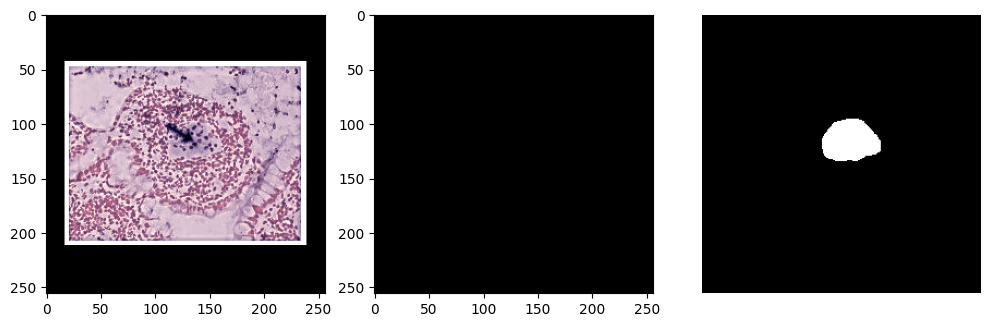

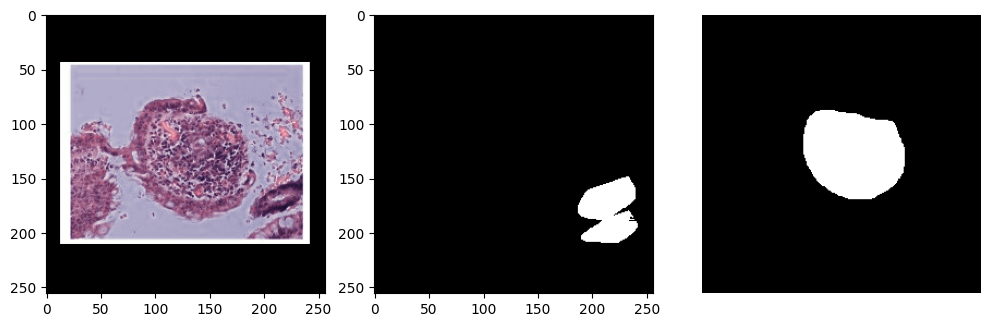

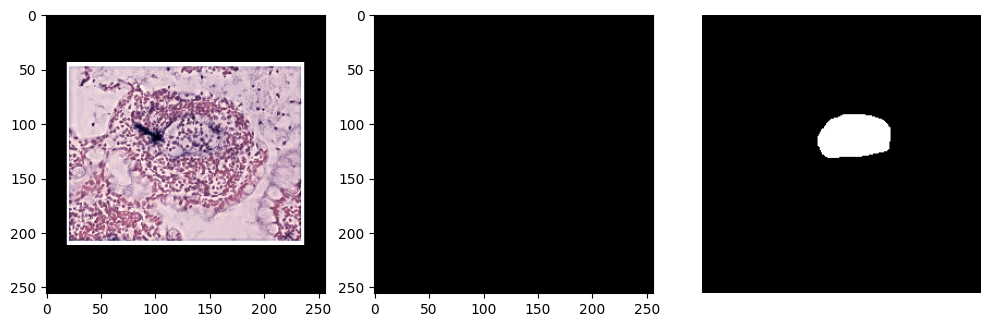

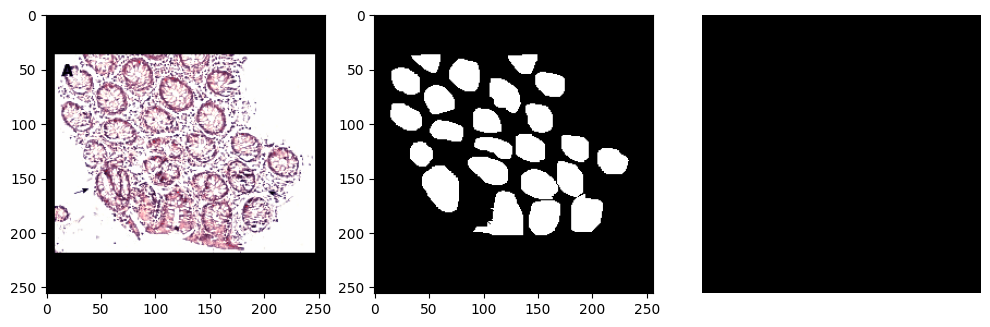

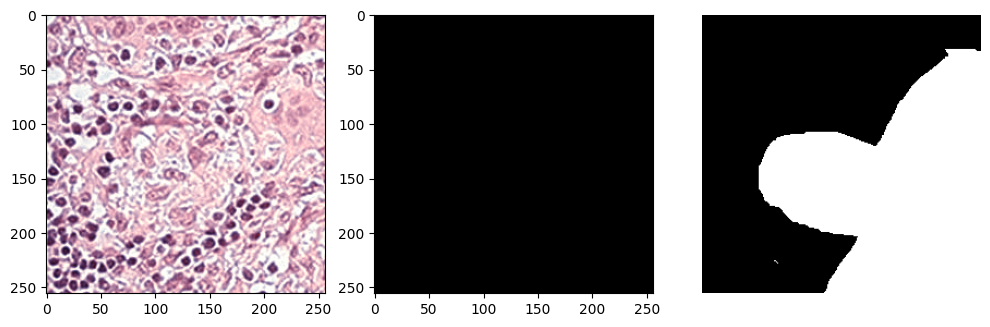

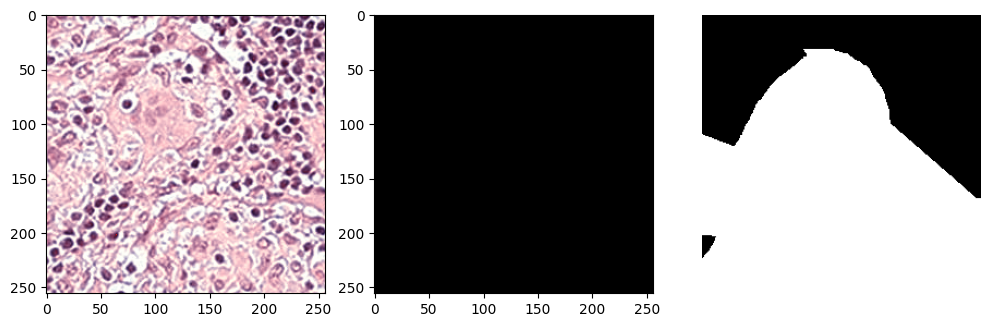

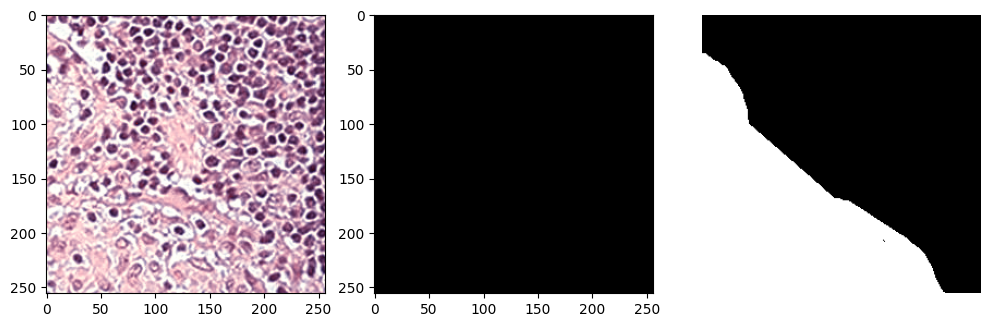

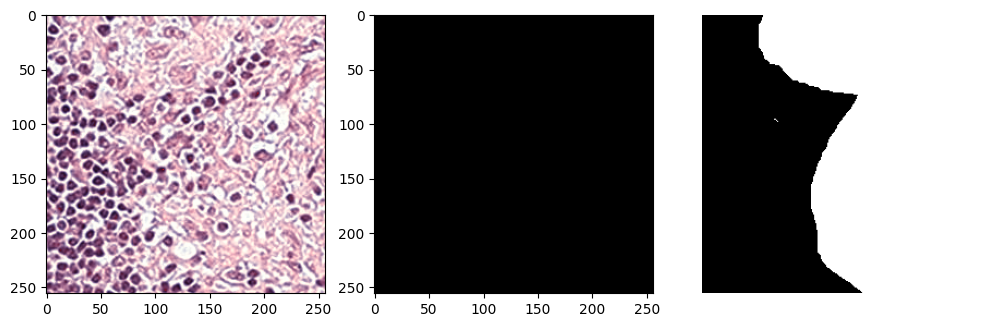

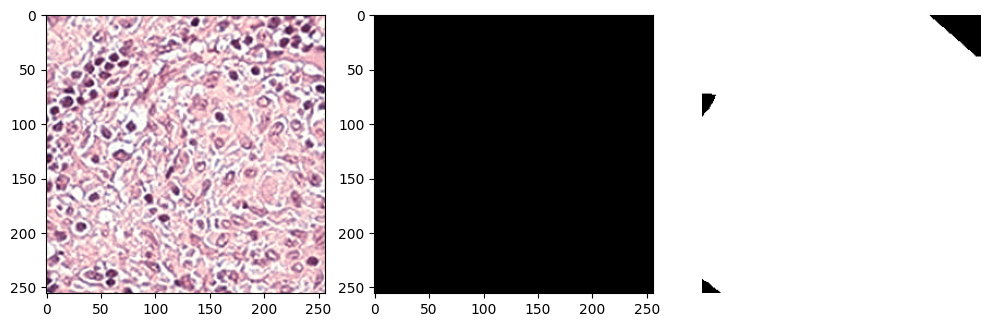

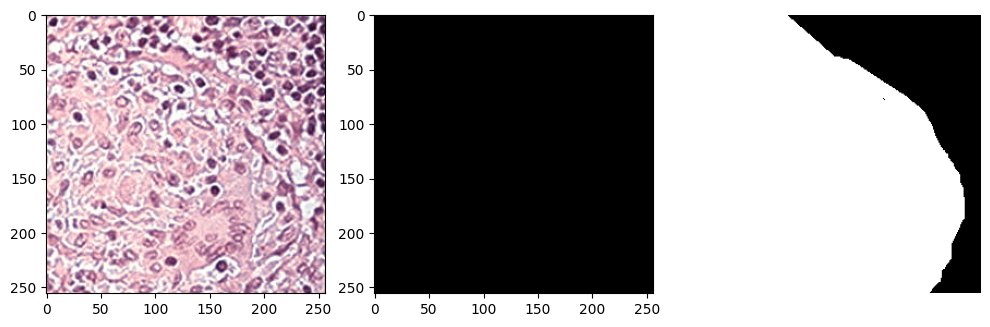

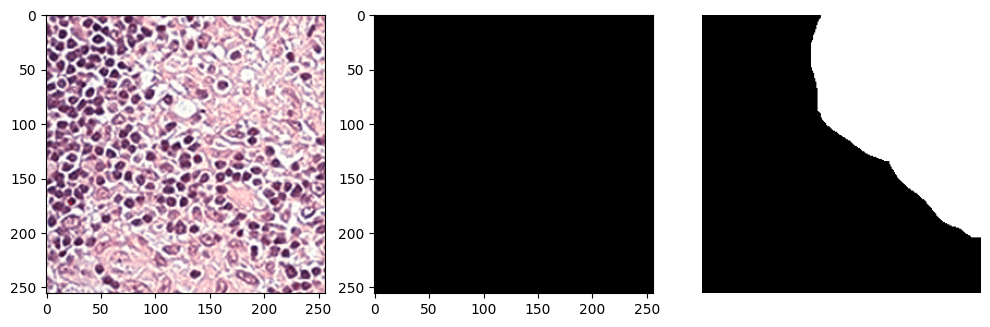

In [26]:
import matplotlib.pyplot as plt
# display the first 9 patches from the dataset
for idx, patch in enumerate(dataset[9:20]):
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 3, 1)
    plt.imshow(patch.img_patch, cmap="gray")
    plt.subplot(3, 3, 2)
    plt.imshow(patch.mask_patch[0], cmap="gray")
    plt.subplot(3, 3,  3)
    plt.imshow(patch.mask_patch[1], cmap="gray")
    plt.axis("off")  # Hide axes
    plt.tight_layout()
    plt.show()